In [1]:
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
import time
import seaborn as sns
from matplotlib.patches import Ellipse
from kneed import KneeLocator
import itertools
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from sklearn.decomposition import FastICA
from numpy import linalg
from sklearn.random_projection import GaussianRandomProjection
from sklearn import metrics
from itertools import product
from collections import defaultdict
from sklearn.manifold import LocallyLinearEmbedding
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import rcParams
import time

In [2]:
RANDOM_STATE = 101
seeds = [1, 10, 25, 50, 101]

In [3]:
# Breast Cancer Data
# fetch dataset 
bc_df = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = bc_df.data.features 
y = bc_df.data.targets 

In [4]:
# Split into training and testing sets. Don't use test set until the very end
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE, stratify = y)

## ICA

In [5]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('norm', MinMaxScaler()), ('sm', SMOTE(random_state=101)),
                ('model',
                 MLPClassifier(alpha=0.1, early_stopping=True,
                               hidden_layer_sizes=(100, 100, 100),
                               max_iter=2000, random_state=101))])

In [6]:
y_pred = pipeline.predict(X_test)

In [7]:
# print classification report 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       0.93      0.96      0.95        72
           M       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



In [8]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
pipeline.fit(X_train, y_train.values.ravel())
train_sizes, train_scores, validation_scores = learning_curve(
estimator = pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

### Final Model

In [9]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.5, hidden_layer_sizes=(150,150,))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
ica = FastICA(n_components=27, random_state=RANDOM_STATE)
ica_pipeline = Pipeline([('norm', norm), ('ica', ica), ('sm', sm), ('model', clf)])
t0 = time.time()
ica_pipeline.fit(X_train, y_train.values.ravel())
print("Training time:", time.time()-t0)

Training time: 0.36211705207824707


In [10]:
ica_y_pred = ica_pipeline.predict(X_test)

In [11]:
# print classification report 
print(classification_report(y_test, ica_y_pred)) 

              precision    recall  f1-score   support

           B       0.96      0.96      0.96        72
           M       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [12]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.5, hidden_layer_sizes=(150,150,))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
ica = FastICA(n_components=27, random_state=RANDOM_STATE, max_iter=500)
ica_pipeline = Pipeline([('norm', norm), ('ica', ica), ('sm', sm), ('model', clf)])
ica_pipeline.fit(X_train, y_train.values.ravel())
ica_train_sizes, ica_train_scores, ica_validation_scores = learning_curve(
estimator = ica_pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


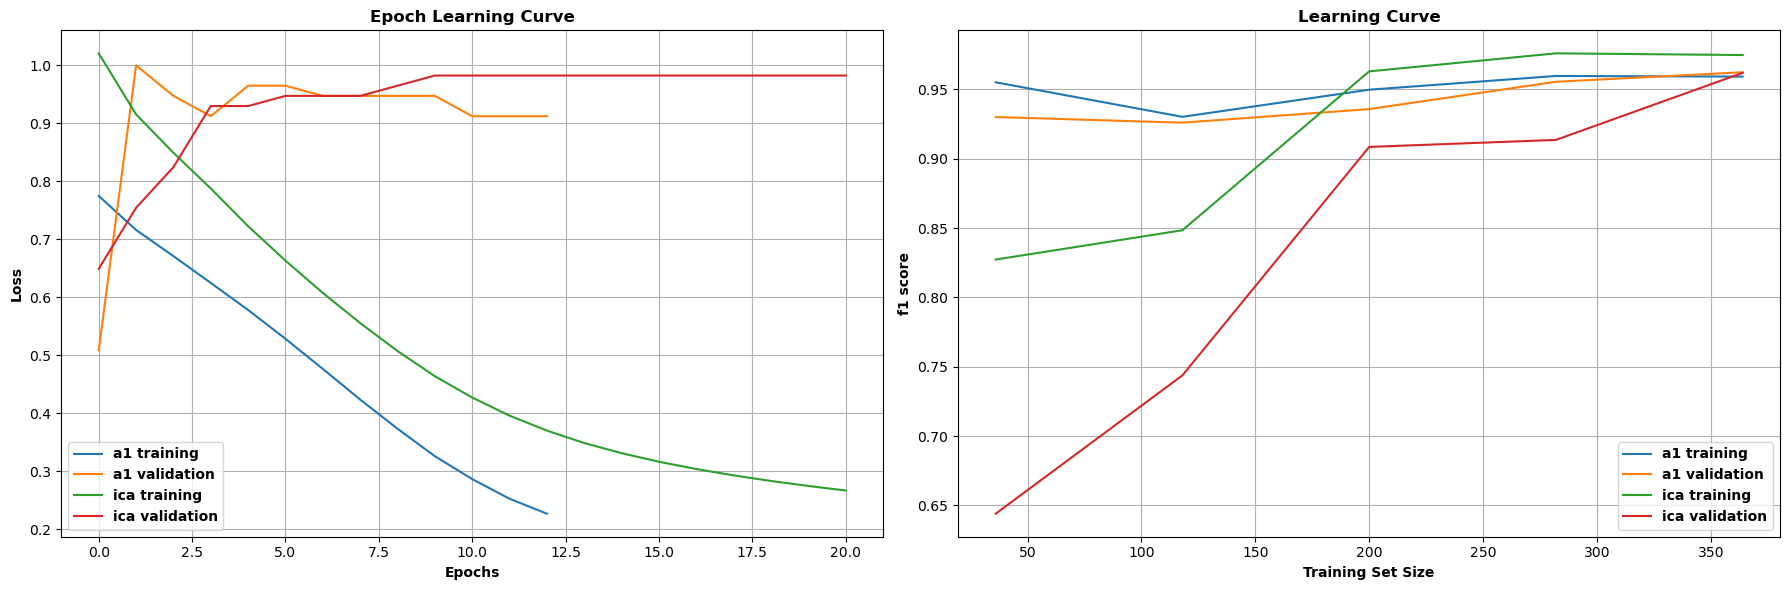

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
rcParams['font.weight'] = 'bold'
ica_train_mean = ica_train_scores.mean(axis=1)
ica_validation_mean = ica_validation_scores.mean(axis=1)
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)

ax1.plot(pipeline['model'].loss_curve_, label='a1 training')
ax1.plot(pipeline['model'].validation_scores_, label='a1 validation')
ax1.plot(ica_pipeline['model'].loss_curve_, label='ica training')
ax1.plot(ica_pipeline['model'].validation_scores_, label='ica validation')
ax1.legend(loc="best", prop = { 'weight':'bold'})
ax1.set_xlabel('Epochs', weight='bold')
ax1.set_title('Epoch Learning Curve', weight='bold')
ax1.set_ylabel('Loss', weight='bold')
ax1.grid()

ax2.plot(train_sizes, train_mean, label="a1 training")
ax2.plot(train_sizes, validation_mean, label="a1 validation")
ax2.plot(ica_train_sizes, ica_train_mean, label="ica training")
ax2.plot(ica_train_sizes, ica_validation_mean, label="ica validation")

ax2.set_title("Learning Curve", weight='bold')
ax2.set_xlabel("Training Set Size", weight='bold')
ax2.set_ylabel("f1 score", weight='bold')
ax2.legend(loc="best", prop = { 'weight':'bold'})
ax2.grid()

plt.tight_layout()
plt.savefig(f'plots/dim_red_nn/bc_ica_learning.png', dpi=300)
plt.show()

### Validation Curves

In [14]:
from sklearn.model_selection import validation_curve

In [15]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True)
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
ica = FastICA(n_components=27, random_state=RANDOM_STATE, max_iter=500)
ica_pipeline = Pipeline([('norm', norm), ('ica', ica), ('sm', sm), ('model', clf)])

#### Width

In [16]:
width_parameter_range = [(5,), (10,), (20,), (50,), (100,), (150,), (200,), (250,), (300,)]
width_train_score, width_test_score = validation_curve(ica_pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__hidden_layer_sizes",
                                           param_range=width_parameter_range,
                                           cv=5, scoring="f1_macro")

/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/env

#### Depth

In [17]:
depth_parameter_range = [(150,), (150,150), (150,150,150), (150,150,150,150), (150,150,150,150,150)]
    # (5,), (5,5), (5,5,5), (5,5,5,5), (5,5,5,5,5), (5,5,5,5,5,5)]
                   # , (10,), (10,10), (10,10,10), (10,10,10,10)]
depth_train_score, depth_test_score = validation_curve(ica_pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__hidden_layer_sizes",
                                           param_range=depth_parameter_range,
                                           cv=5, scoring="f1_macro")

/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/env

#### Alpha

In [18]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, hidden_layer_sizes=(150,))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
ica = FastICA(n_components=27, random_state=RANDOM_STATE, max_iter=500)
ica_pipeline = Pipeline([('norm', norm), ('ica', ica), ('sm', sm), ('model', clf)])
alpha_parameter_range = [0.0001, 0.01, 0.05, 0.1, 0.5, 0.75, 1]
alpha_train_score, alpha_test_score = validation_curve(ica_pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__alpha",
                                           param_range=alpha_parameter_range,
                                           cv=5, scoring="f1_macro")

/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/envs/ML_A3_env/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/VivianNTran/anaconda3/env

### Cumulative Validation Plots

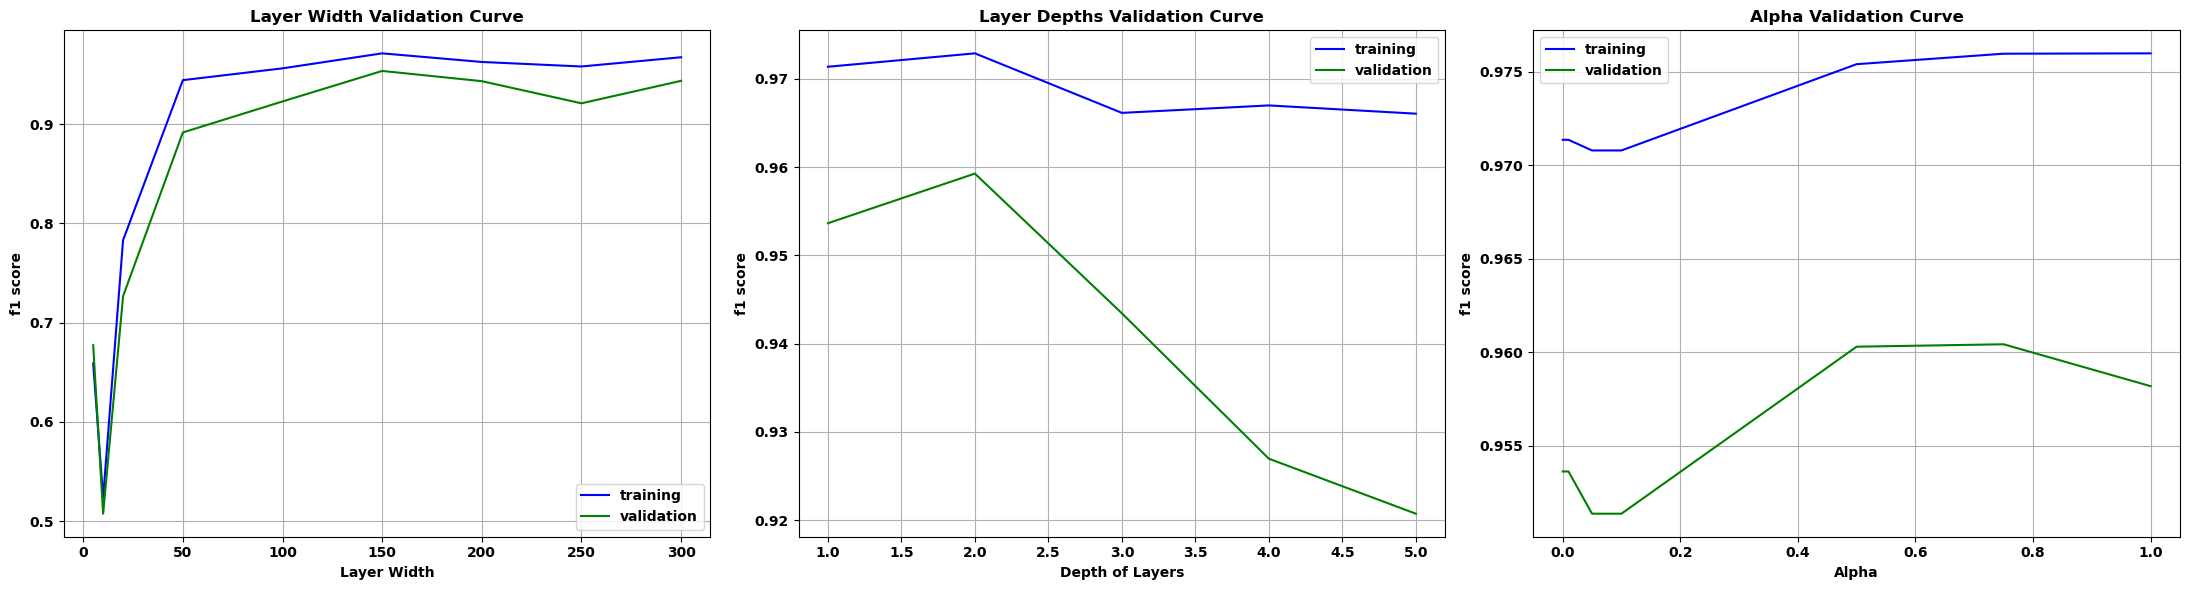

In [19]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(22, 6))
rcParams['font.weight'] = 'bold'

# Width
# Calculating mean and standard deviation of training score
width_mean_train_score = np.mean(width_train_score, axis=1)
width_std_train_score = np.std(width_train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
width_mean_test_score = np.mean(width_test_score, axis=1)
width_std_test_score = np.std(width_test_score, axis=1)

width_parameter_range = [5, 10, 20, 50, 100, 150, 200, 250, 300]
# Plot mean accuracy scores for training and testing scores
ax1.plot(width_parameter_range, width_mean_train_score,
         label="training", color='b')
ax1.plot(width_parameter_range, width_mean_test_score,
         label="validation", color='g')
 
# Creating the plot
ax1.set_title("Layer Width Validation Curve", weight='bold')
ax1.set_xlabel("Layer Width", weight='bold')
ax1.set_ylabel("f1 score", weight='bold')
ax1.legend(loc='best', prop = { 'weight':'bold'})
ax1.grid()

# Depth
# Calculating mean and standard deviation of training score
depth_mean_train_score = np.mean(depth_train_score, axis=1)
depth_std_train_score = np.std(depth_train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
depth_mean_test_score = np.mean(depth_test_score, axis=1)
depth_std_test_score = np.std(depth_test_score, axis=1)

depth_parameter_range = [1, 2, 3, 4, 5]
# Plot mean accuracy scores for training and testing scores
ax2.plot(depth_parameter_range, depth_mean_train_score,
         label="training", color='b')
ax2.plot(depth_parameter_range, depth_mean_test_score,
         label="validation", color='g')
 
# Creating the plot
ax2.set_title("Layer Depths Validation Curve", weight='bold')
ax2.set_xlabel("Depth of Layers", weight='bold')
ax2.set_ylabel("f1 score", weight='bold')
ax2.legend(loc='best', prop = { 'weight':'bold'})
ax2.grid()

# Alpha
# Calculating mean and standard deviation of training score
alpha_mean_train_score = np.mean(alpha_train_score, axis=1)
alpha_std_train_score = np.std(alpha_train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
alpha_mean_test_score = np.mean(alpha_test_score, axis=1)
alpha_std_test_score = np.std(alpha_test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
ax3.plot(alpha_parameter_range, alpha_mean_train_score,
         label="training", color='b')
ax3.plot(alpha_parameter_range, alpha_mean_test_score,
         label="validation", color='g')
 
# Creating the plot
ax3.set_title("Alpha Validation Curve", weight='bold')
ax3.set_xlabel("Alpha", weight='bold')
ax3.set_ylabel("f1 score", weight='bold')
ax3.legend(loc='best', prop = { 'weight':'bold'})
ax3.grid()

plt.tight_layout()
plt.savefig(f'plots/dim_red_nn/bc_ica_validation.png', dpi=300)
plt.tight_layout()

## Manifold Learning: LLE

In [20]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('norm', MinMaxScaler()), ('sm', SMOTE(random_state=101)),
                ('model',
                 MLPClassifier(alpha=0.1, early_stopping=True,
                               hidden_layer_sizes=(100, 100, 100),
                               max_iter=2000, random_state=101))])

In [21]:
y_pred = pipeline.predict(X_test)

In [22]:
# print classification report 
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       0.93      0.96      0.95        72
           M       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



In [23]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=.1, hidden_layer_sizes=(100,100,100))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
pipeline = Pipeline([('norm', norm), ('sm', sm), ('model', clf)])
pipeline.fit(X_train, y_train.values.ravel())
train_sizes, train_scores, validation_scores = learning_curve(
estimator = pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

### Final Model

In [24]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=0, hidden_layer_sizes=(100,100,100,100,))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=4, random_state=RANDOM_STATE, n_jobs=-1)
lle_pipeline = Pipeline([('norm', norm), ('lle', lle), ('sm', sm), ('model', clf)])
t0 = time.time()
lle_pipeline.fit(X_train, y_train.values.ravel())
print("Training time:", time.time()-t0)

Training time: 0.26589512825012207


In [25]:
lle_y_pred = lle_pipeline.predict(X_test)

In [26]:
# print classification report 
print(classification_report(y_test, lle_y_pred)) 

              precision    recall  f1-score   support

           B       0.93      0.93      0.93        72
           M       0.88      0.88      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



In [27]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, alpha=0, hidden_layer_sizes=(100,100,100,100,))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=4, random_state=RANDOM_STATE, n_jobs=-1)
lle_pipeline = Pipeline([('norm', norm), ('lle', lle), ('sm', sm), ('model', clf)])
lle_pipeline.fit(X_train, y_train.values.ravel())
lle_train_sizes, lle_train_scores, lle_validation_scores = learning_curve(
estimator = lle_pipeline,
X = X_train,
y = y_train.values.ravel(), cv = 5,
scoring = 'f1_macro',
random_state=RANDOM_STATE)

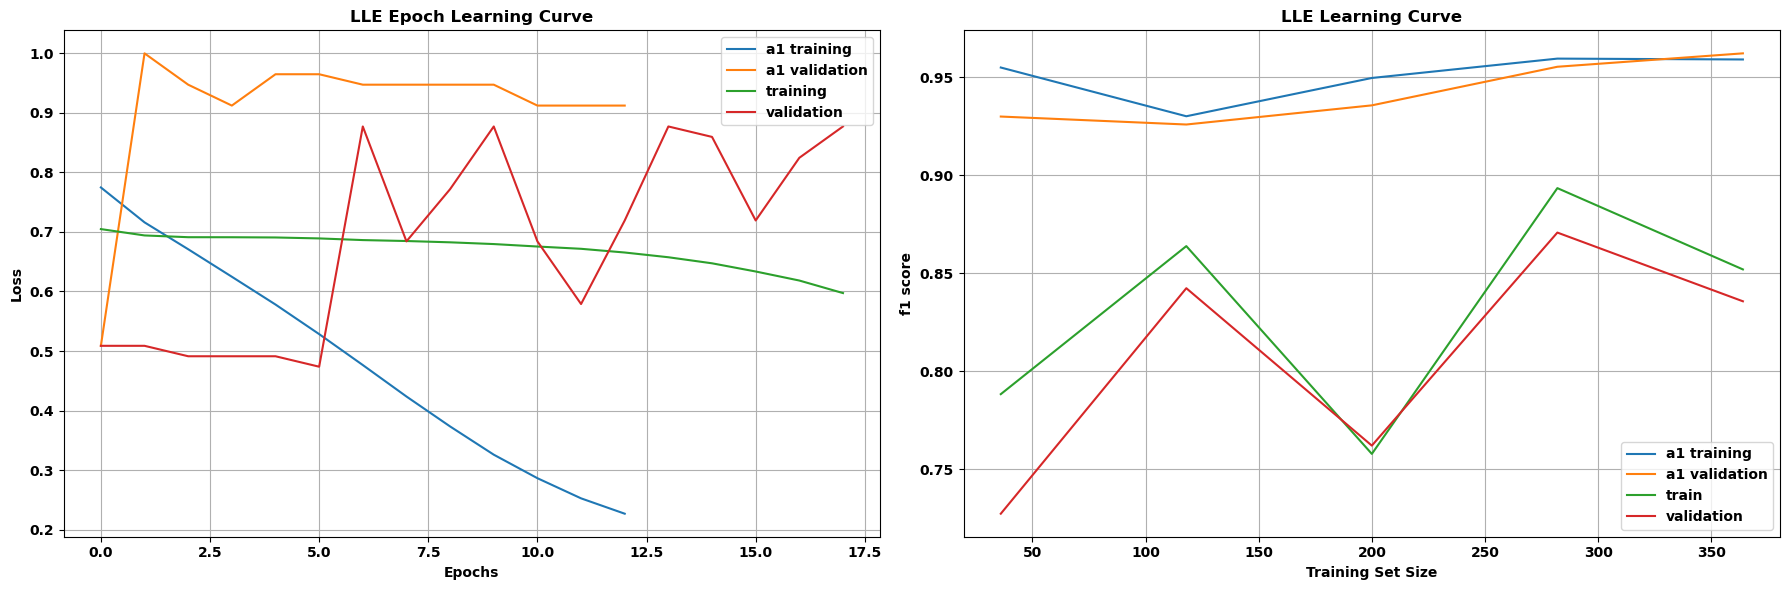

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
rcParams['font.weight'] = 'bold'
lle_train_mean = lle_train_scores.mean(axis=1)
lle_validation_mean = lle_validation_scores.mean(axis=1)
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)

ax1.plot(pipeline['model'].loss_curve_, label='a1 training')
ax1.plot(pipeline['model'].validation_scores_, label='a1 validation')
ax1.plot(lle_pipeline['model'].loss_curve_, label='training')
ax1.plot(lle_pipeline['model'].validation_scores_, label='validation')
ax1.legend(loc="best", prop = { 'weight':'bold'})
ax1.set_xlabel('Epochs', weight='bold')
ax1.set_title('LLE Epoch Learning Curve', weight='bold')
ax1.set_ylabel('Loss', weight='bold')
ax1.grid()

ax2.plot(train_sizes, train_mean, label="a1 training")
ax2.plot(train_sizes, validation_mean, label="a1 validation")
ax2.plot(lle_train_sizes, lle_train_mean, label="train")
ax2.plot(lle_train_sizes, lle_validation_mean, label="validation")

ax2.set_title("LLE Learning Curve", weight='bold')
ax2.set_xlabel("Training Set Size", weight='bold')
ax2.set_ylabel("f1 score", weight='bold')
ax2.legend(loc="best", prop = { 'weight':'bold'})
ax2.grid()

plt.tight_layout()
plt.savefig(f'plots/dim_red_nn/bc_lle_learning.png', dpi=300)
plt.show()

### Validation Curves

In [29]:
from sklearn.model_selection import validation_curve

In [30]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True)
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=4, random_state=RANDOM_STATE, n_jobs=-1)
lle_pipeline = Pipeline([('norm', norm), ('lle', lle), ('sm', sm), ('model', clf)])

#### Width

In [31]:
width_parameter_range = [(5,), (10,), (20,), (50,), (100,), (150,), (200,), (250,), (300,)]
width_train_score, width_test_score = validation_curve(lle_pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__hidden_layer_sizes",
                                           param_range=width_parameter_range,
                                           cv=5, scoring="f1_macro")

#### Depth

In [32]:
depth_parameter_range = [(100,), (100,100), (100,100,100), (100,100,100,100), (100,100,100,100,100)]
    # (5,), (5,5), (5,5,5), (5,5,5,5), (5,5,5,5,5), (5,5,5,5,5,5)]
                   # , (10,), (10,10), (10,10,10), (10,10,10,10)]
depth_train_score, depth_test_score = validation_curve(lle_pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__hidden_layer_sizes",
                                           param_range=depth_parameter_range,
                                           cv=5, scoring="f1_macro")

#### Alpha

In [33]:
clf = MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, early_stopping=True, hidden_layer_sizes=(100,100,100,100,))
sm = SMOTE(random_state=RANDOM_STATE)
norm = MinMaxScaler()
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=4, random_state=RANDOM_STATE, n_jobs=-1)
lle_pipeline = Pipeline([('norm', norm), ('lle', lle), ('sm', sm), ('model', clf)])
alpha_parameter_range = [0.0001, 0.01, 0.05, 0.1, 0.5, 0.75, 1]
alpha_train_score, alpha_test_score = validation_curve(lle_pipeline, X_train, y_train.values.ravel(),
                                           param_name="model__alpha",
                                           param_range=alpha_parameter_range,
                                           cv=5, scoring="f1_macro")

### Cumulative Validation Plots

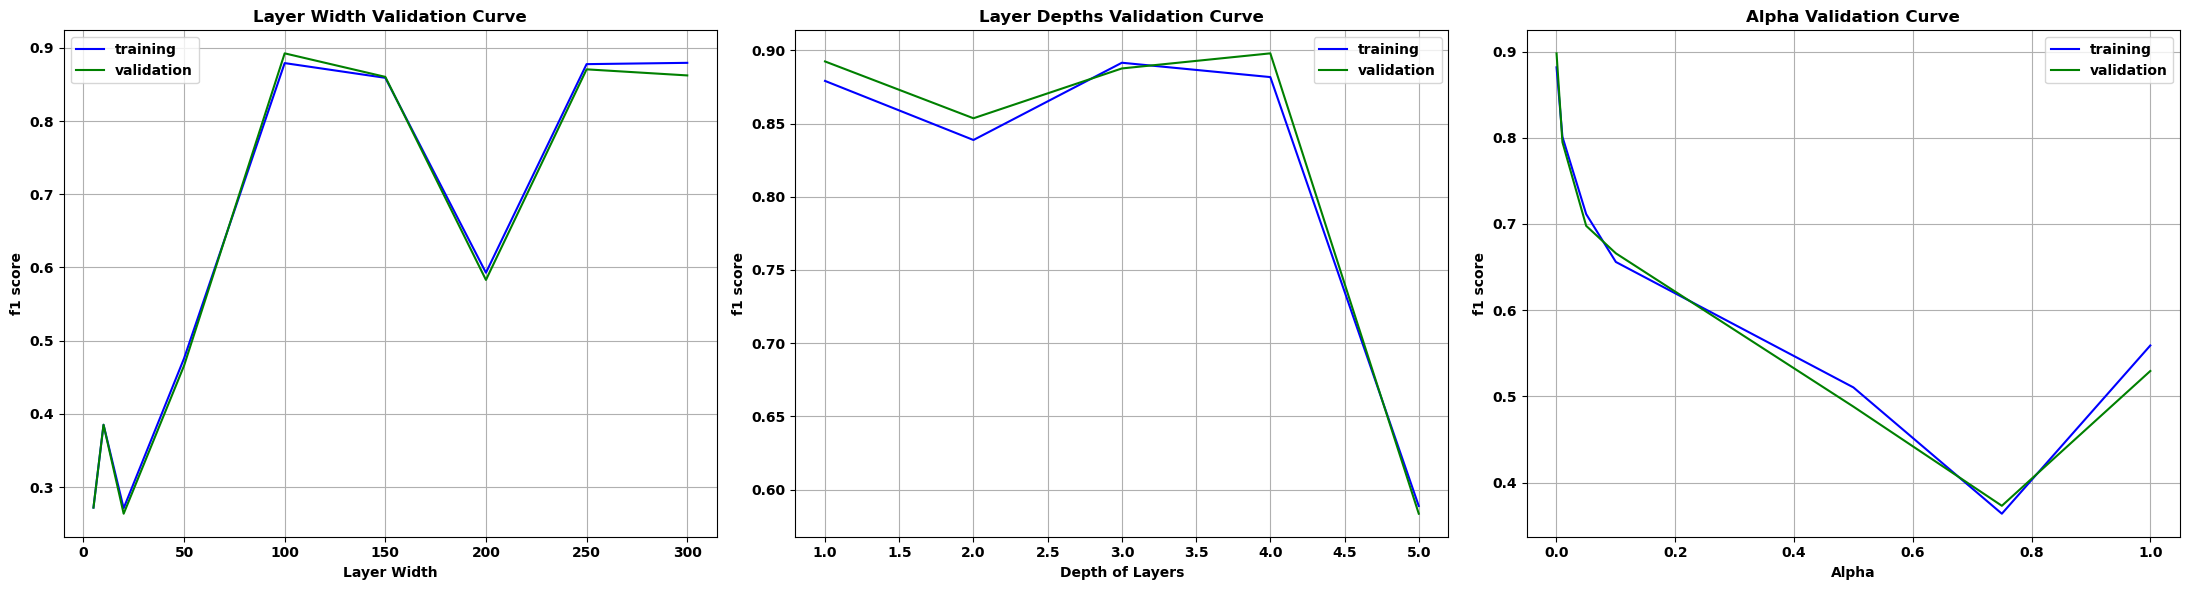

In [34]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(22, 6))
rcParams['font.weight'] = 'bold'

# Width
# Calculating mean and standard deviation of training score
width_mean_train_score = np.mean(width_train_score, axis=1)
width_std_train_score = np.std(width_train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
width_mean_test_score = np.mean(width_test_score, axis=1)
width_std_test_score = np.std(width_test_score, axis=1)

width_parameter_range = [5, 10, 20, 50, 100, 150, 200, 250, 300]
# Plot mean accuracy scores for training and testing scores
ax1.plot(width_parameter_range, width_mean_train_score,
         label="training", color='b')
ax1.plot(width_parameter_range, width_mean_test_score,
         label="validation", color='g')
 
# Creating the plot
ax1.set_title("Layer Width Validation Curve", weight='bold')
ax1.set_xlabel("Layer Width", weight='bold')
ax1.set_ylabel("f1 score", weight='bold')
ax1.legend(loc='best', prop = { 'weight':'bold'})
ax1.grid()

# Depth
# Calculating mean and standard deviation of training score
depth_mean_train_score = np.mean(depth_train_score, axis=1)
depth_std_train_score = np.std(depth_train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
depth_mean_test_score = np.mean(depth_test_score, axis=1)
depth_std_test_score = np.std(depth_test_score, axis=1)

depth_parameter_range = [1, 2, 3, 4, 5]
# Plot mean accuracy scores for training and testing scores
ax2.plot(depth_parameter_range, depth_mean_train_score,
         label="training", color='b')
ax2.plot(depth_parameter_range, depth_mean_test_score,
         label="validation", color='g')
 
# Creating the plot
ax2.set_title("Layer Depths Validation Curve", weight='bold')
ax2.set_xlabel("Depth of Layers", weight='bold')
ax2.set_ylabel("f1 score", weight='bold')
ax2.legend(loc='best', prop = { 'weight':'bold'})
ax2.grid()

# Alpha
# Calculating mean and standard deviation of training score
alpha_mean_train_score = np.mean(alpha_train_score, axis=1)
alpha_std_train_score = np.std(alpha_train_score, axis=1)
 
# Calculating mean and standard deviation of testing score
alpha_mean_test_score = np.mean(alpha_test_score, axis=1)
alpha_std_test_score = np.std(alpha_test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
ax3.plot(alpha_parameter_range, alpha_mean_train_score,
         label="training", color='b')
ax3.plot(alpha_parameter_range, alpha_mean_test_score,
         label="validation", color='g')
 
# Creating the plot
ax3.set_title("Alpha Validation Curve", weight='bold')
ax3.set_xlabel("Alpha", weight='bold')
ax3.set_ylabel("f1 score", weight='bold')
ax3.legend(loc='best', prop = { 'weight':'bold'})
ax3.grid()

plt.tight_layout()
plt.savefig(f'plots/dim_red_nn/bc_lle_validation.png', dpi=300)
plt.tight_layout()